# Variational inference using the finite approximation

trying cavi + annealing

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [23]:
# np.random.seed(12321) # this is a seed where annealing works well 
# np.random.seed(43141) # this is a seed that works well too :)
# np.random.seed(341708970) # this too!

# np.random.seed(14314) 
np.random.seed(4234) # this less so ...

# np.random.seed(123414) # this one is pretty meh 
    # gets one column absolutely correct # stull better than CAVI though



Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps)

# set initializations
K_approx = deepcopy(K_inf) # variational truncation
tau, nu, phi_mu, phi_var = initialize_parameters(Num_samples, D, K_approx)

Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}




In [24]:
"""
# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
#print(mu)
#print(sigma_A*np.identity(D))
#print(K_inf)
#A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)
epsilon = np.random.normal(0, sigma_eps, (Num_samples, D))

# the observed data
X = np.dot(Z,A) + epsilon
"""

"""
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)

"""



'\nK_approx = deepcopy(K_inf) # variational truncation\n\ntau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v\n#tau = np.ones([K_approx,2])*1000\n#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi\n\n#nu = np.ones([Num_samples, K_approx]) *0.0\nnu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk\n#nu = deepcopy(Z)\n\nphi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column\n#phi_mu = deepcopy(A).T\nphi_var = np.ones(K_approx)\n\nnu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)\n\nelbo = np.zeros(iterations)\nelbo_Term1 = np.zeros(iterations)\nelbo_Term2 = np.zeros(iterations)\nelbo_Term3 = np.zeros(iterations)\nelbo_Term4 = np.zeros(iterations)\nelbo_Term5 = np.zeros(iterations)\nelbo_Term6 = np.zeros(iterations)\nelbo_Term7 = np.zeros(iterations)\n\n'

In [25]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

# run CAVI

In [26]:
iterations = 1000

phi_mu_traj1 = np.zeros([10 * 1000 , 2])
phi_mu_traj2 = np.zeros([10 * 1000 , 2])
phi_mu_traj3 = np.zeros([10 * 1000 , 2])

sigma_eps_anneal = np.linspace(100, sigma_eps, 10)

tol = [10**(-2)]* 2 + [10**(-4)]*3 + [10**(-6)]*3 + [10**(-8)]*2 # set sequence of tolerances
#tol = [10**(-1)]*90 + [10**(-2)]* 2  + [10**(-4)]*3 + [10**(-6)]*3 + [10**(-8)]*2
assert len(tol) == len(sigma_eps_anneal)


total_iter = 0
for j in range(len(sigma_eps_anneal)): 
    
    sigmas['eps'] = sigma_eps_anneal[j]
    print('anneal iteration: ', j, 'sigma_eps', sigmas['eps'])
    
    elbo = np.zeros(iterations)
    
    for i in range(iterations):
        
        cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)
        
        phi_mu_traj1[total_iter , :] = phi_mu[:,0]
        phi_mu_traj2[total_iter , :] = phi_mu[:,1]
        phi_mu_traj3[total_iter , :] = phi_mu[:,2]
        
        
        #print(phi_mu_traj1[total_iter , :])
        #print(phi_mu_traj2[total_iter , :])
        #print(phi_mu_traj3[total_iter , :])
        # round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

        elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)[0]

        if i%10 ==0:
            nice_iter_display = str(j)+'-'+str(i) # anneal_iter - cavi_iter
            print('iteration: ', nice_iter_display, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), \
                 'elbo: ', elbo[i])
        #print(round_nu[0:10,:])
        #print(nu[0:10,:])
        #print('l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]) )

        if np.isnan(elbo[i]):
            print('NAN ELBO.')
            break

        if (i>0) & (elbo[i] < elbo[i-1]): 
            print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
            print(i)
            print(elbo[0:i+1])
            break
    
        if np.abs(elbo[i]-elbo[i-1]) <= tol[j]:
            print('ELBO converged ; iterations ran: ', i, '\n')
            break
        
        total_iter += 1
        
#print(phi_mu_traj1[0:10:,:])
#print(phi_mu_traj2[0:10:,:])
#print(phi_mu_traj3[0:10:,:])


anneal iteration:  0 sigma_eps 100.0
iteration:  0-0  l1 error:  0.645064471926 elbo:  -3843.62983618
iteration:  0-10  l1 error:  0.556617880032 elbo:  -3617.96589813
iteration:  0-20  l1 error:  0.543637163187 elbo:  -3615.99961542
iteration:  0-30  l1 error:  0.531200527459 elbo:  -3614.80341714
iteration:  0-40  l1 error:  0.519270655802 elbo:  -3613.95471859
iteration:  0-50  l1 error:  0.507845742793 elbo:  -3613.30602581
iteration:  0-60  l1 error:  0.496913717766 elbo:  -3612.78755737
iteration:  0-70  l1 error:  0.486458265167 elbo:  -3612.3606117
iteration:  0-80  l1 error:  0.476461507879 elbo:  -3612.00144469
iteration:  0-90  l1 error:  0.466905143773 elbo:  -3611.69442449
iteration:  0-100  l1 error:  0.457770977939 elbo:  -3611.42870725
iteration:  0-110  l1 error:  0.44904118976 elbo:  -3611.19645996
iteration:  0-120  l1 error:  0.440698471051 elbo:  -3610.99183886
iteration:  0-130  l1 error:  0.432726096489 elbo:  -3610.81036771
iteration:  0-140  l1 error:  0.425107

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)


iteration:  9-0  l1 error:  0.129333333333 elbo:  -40859.6910595
iteration:  9-10  l1 error:  0.129333333333 elbo:  -40858.880375
iteration:  9-20  l1 error:  0.129333333333 elbo:  -40858.8107755
iteration:  9-30  l1 error:  0.129333333333 elbo:  -40858.8065823
iteration:  9-40  l1 error:  0.129333333333 elbo:  -40858.806341
iteration:  9-50  l1 error:  0.129333333333 elbo:  -40858.8063271
iteration:  9-60  l1 error:  0.129333333333 elbo:  -40858.8063263
ELBO converged ; iterations ran:  62 



# Examine results

Z (unpermuted): 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [0, 1, 2]
Z (permuted) 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]]
round_nu 
 [[ 0.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  1.]]
l1 error (after permutation):  [0.14599999999999999, 0.17199999999999999, 0.070000000000000007]


true A (permuted): 
 [[ -4.94188276 -20.26363075]
 [  7.72169227 -14.61881616]
 [ -2.47579307  13.17264379]]
phi_mu: 
 [[  1.00515685 -17.46121637]
 [  1.77543853 -17.27721921]
 [ -2.56056038  13.38073941]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.68076669  0.95241243  0.87508262]


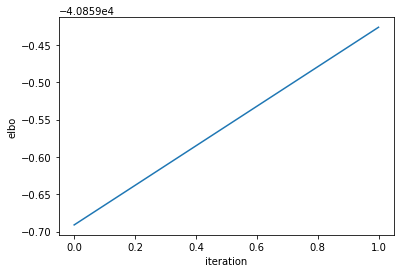

In [32]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:i])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

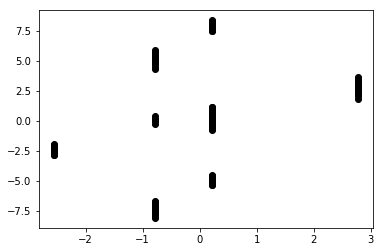

In [33]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 0
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

# Examine trajectories

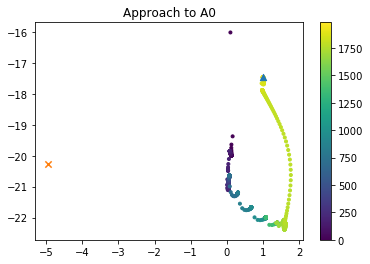

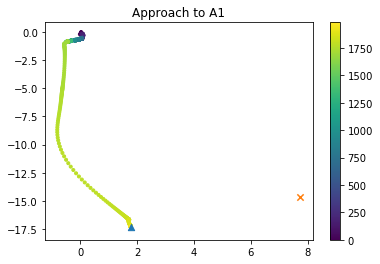

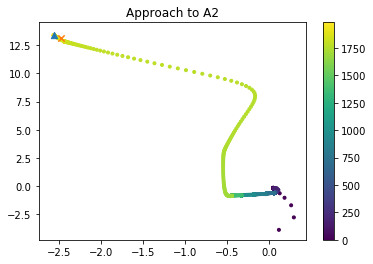

In [34]:
"""phi_mu_traj1 = phi_mu_traj1[:total_iter, :]
phi_mu_traj2 = phi_mu_traj2[:total_iter, :]
phi_mu_traj3 = phi_mu_traj3[:total_iter, :]

print(phi_mu_traj1[0:10:,:])
print(phi_mu_traj2[0:10:,:])
print(phi_mu_traj3[0:10:,:])
"""

traj = np.concatenate((phi_mu_traj1, phi_mu_traj2, phi_mu_traj3), 1)
#print(traj[0:10:,:])

traj = traj[:total_iter,:]

t = np.arange(total_iter) # lighter colors mean later iterations


for i in range(K_approx):
    plt.scatter(traj[:,2*i], traj[:,2*i+1], c=t, cmap='viridis', marker = '.')
    #plt.scatter(phi_mu_traj2[:,0], phi_mu_traj2[:,1], c=t, cmap='viridis')
    plt.colorbar()

    # the final estimate
    plt.scatter(phi_mu[0,i], phi_mu[1,i], marker = '^', s=40)

    # the truth
    A_perm = A[perm, :]
    plt.scatter(A_perm[i,0], A_perm[i,1], marker = 'x', s=40)
    
    title = 'Approach to A'+str(i)
    plt.title(title)
    plt.show()


